In [1]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from fbprophet import Prophet

%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('analysis_data_set.csv', dtype={'tweet_id': 'object'})

In [3]:
df['created_at'] = pd.to_datetime(df.created_at)

In [4]:
df.describe()

,character_count,rating_ratio,favorite_count,retweet_count
count,1953.000000,1953.000000,1953.000000,1953.000000
mean,111.822837,1.164863,8908.530978,2761.408090
std,26.231909,4.106254,12212.221822,4638.821601
min,13.000000,0.000000,81.000000,16.000000
25%,94.000000,1.000000,1985.000000,629.000000
50%,116.000000,1.100000,4134.000000,1366.000000
75%,137.000000,1.200000,11394.000000,3238.000000
max,148.000000,177.600000,132810.000000,79515.000000


In [5]:
'''Will remove both 177.6 and 42.0 from ratings as they are more 
than two standard deviations from the mean, and I believe that 
they were given based on the dates July 4th, and April 20th 
rather than as a genuine rating'''

max_rating = df.rating_ratio.sort_values(ascending=False)[:2].to_list()

df = df.query('rating_ratio not in @max_rating')

### Top Breeds

In [6]:
# breed count

breed_count = df.query('dog == True')\
.groupby('breed').count()[['tweet_id']]\
.sort_values('tweet_id', ascending=False)[:20]


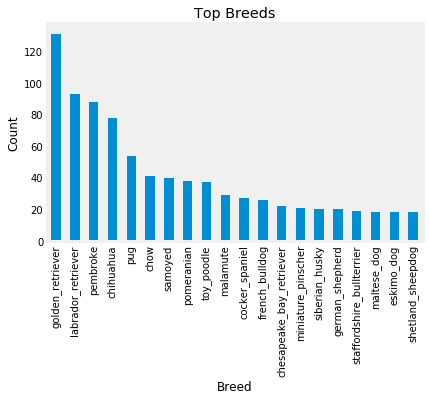

In [7]:
breed_count.plot(kind='bar', legend=False)
plt.title("Top Breeds")
plt.xlabel("Breed")
plt.ylabel("Count")
plt.grid();

As we can see, the top breed identified by the image classifier by a wide margin is golden retriever, followed by labrador retriever.

In [8]:
# average likes and retweets of top dogs

avg_likes_retweets = df.query('dog == True').groupby('breed').mean()[['favorite_count', 'retweet_count']]
avg_likes_retweets['count'] = df.query('dog == True').groupby('breed').count()[['tweet_id']]

In [35]:
# variable correlation

avg_likes_retweets.corr()

,favorite_count,retweet_count,count
favorite_count,1.000000,0.921326,0.189766
retweet_count,0.921326,1.000000,0.233091
count,0.189766,0.233091,1.000000


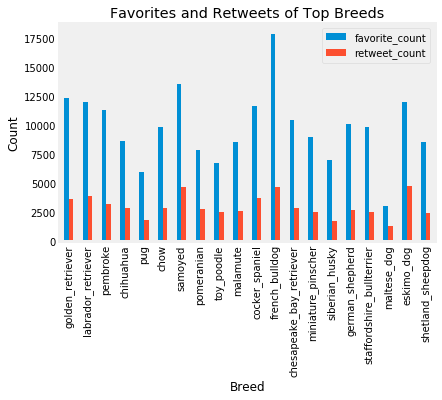

In [9]:
# favorites and retweets of top dog breeds

avg_likes_retweets.sort_values('count', ascending=False)[['favorite_count', 'retweet_count']][:20]\
.plot(kind='bar')
plt.title('Favorites and Retweets of Top Breeds')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.grid();

The frequency of a particular breed does not a particularly strong correlation with either mean favorite or retweet count as it is 0.18 and 0.23 respectively.

### Wordcloud Dog vs. Not Dog

In [10]:
# word cloud dog vs not 

dog = " ".join(tweet for tweet in df.query('dog == True').text)
not_dog = " ".join(tweet for tweet in df.query('dog == False').text)

stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'ckin', 'meet', 'say', 'hello', 'ck', 'dog'])

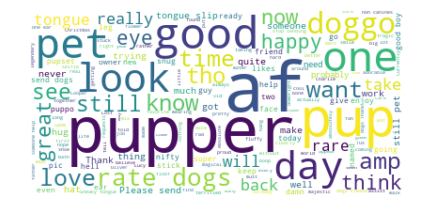

In [11]:
# dog word cloud

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(dog)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

While inspecting the text where dog is True, we see a lot of words such as pupper, pup, pet etc and these ten

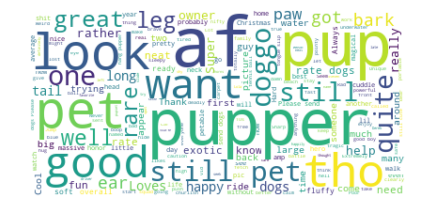

In [12]:
# not dog word cloud

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(not_dog)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

When looking where dog is set to false - it is evident that the majority of the posts are still discussing dogs as pupper, pup, bark and other dog related words still appear.  This indicates that using the image classification test with the highest confidence interval may not have been the best idea, and this is something that I would dig into in the second iteration of this project.

In [13]:
df.query('dog == False').groupby('breed').count()[['tweet_id']]\
.sort_values('tweet_id', ascending=False)[:5]

,tweet_id
breed,
seat_belt,21
teddy,17
web_site,14
dingo,8
tennis_ball,8


Though, investigating further, I see that seat_belt has been tagged 21 times where dog == False.

In [14]:
# reviewing images for the top dog=False breed - seat_belt.

df.query('breed == "seat_belt"').sample(3)

,tweet_id,created_at,source,text,character_count,name,dog,breed,dogtionary,rating_ratio,favorite_count,retweet_count,expanded_urls,jpg_url
657,757400162377592832,2016-07-25 02:20:45,Twitter iPhone,She walks herself up and down the train to be ...,101,NaN,False,seat_belt,NaN,1.3,16743,7759,https://twitter.com/dog_rates/status/757400162...,https://pbs.twimg.com/media/CoLTbbzXYAElNM6.jpg
749,745712589599014916,2016-06-22 20:18:30,Twitter iPhone,This is Percy. He fell asleep at the wheel. Ir...,97,Percy,False,seat_belt,NaN,0.7,7652,2636,https://twitter.com/dog_rates/status/745712589...,https://pbs.twimg.com/media/CllNnkWWMAEDIAR.jpg
1323,681339448655802368,2015-12-28 05:02:37,Twitter iPhone,This is Asher. He's not wearing a seatbelt or ...,139,Asher,False,seat_belt,NaN,0.9,10202,4598,https://twitter.com/dog_rates/status/681339448...,https://pbs.twimg.com/media/CXSanNkWkAAqR9M.jpg


Tweet id #757400162377592832's breed is tagged as seatbelt.  Manually inspecting the photo reveals that it is infact a golden retriever puppy.

<img src="https://pbs.twimg.com/media/CoLTbbzXYAElNM6.jpg" width="200">

### Rating Ratio vs Favorite:Retweet Ratio

In [15]:
# Group by month 
df_day = df.copy()

date_fmt = pd.to_datetime(df_day.created_at).dt.strftime('%Y-%m')
df_day['created_at'] = pd.to_datetime(date_fmt)

forcast = df_day.groupby('created_at').mean()[:-1]

In [36]:
# create retweet:favorite ratio, and the tweet count column

forcast['favorite_retweet_ratio'] = forcast.retweet_count / forcast.favorite_count
forcast['tweet_count'] = df_day.groupby('created_at').count()['tweet_id']

forcast.head()

,character_count,dog,rating_ratio,favorite_count,retweet_count,favorite_retweet_ratio,tweet_count
created_at,,,,,,,
2015-11-01,123.160959,0.650685,0.888699,1222.883562,531.678082,0.434774,292
2015-12-01,115.533520,0.670391,0.955659,3530.756983,1523.589385,0.431519,358
2016-01-01,117.927273,0.745455,1.007879,4000.551515,1524.363636,0.381038,165
2016-02-01,117.092593,0.759259,1.012037,4308.157407,1609.111111,0.373503,108
2016-03-01,118.084746,0.771186,1.038136,4638.567797,1650.754237,0.355876,118


In [17]:
forcast.describe()

,character_count,dog,rating_ratio,favorite_count,retweet_count,favorite_retweet_ratio,tweet_count
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,108.813449,0.777973,1.125259,13430.069980,3860.327513,0.326412,92.809524
std,12.351841,0.060847,0.113226,9371.487745,2108.156613,0.067753,83.440170
min,87.290909,0.650685,0.888699,1222.883562,531.678082,0.215983,38.000000
25%,99.655172,0.758621,1.037037,4703.851852,1650.754237,0.260683,51.000000
50%,115.533520,0.771186,1.119476,11435.476190,4144.794872,0.331245,63.000000
75%,118.000000,0.812500,1.223684,19863.769231,5527.673077,0.356057,84.000000
max,126.026316,0.897959,1.280612,31801.183673,7570.023810,0.435832,358.000000


In [18]:
corr = forcast.loc[:].corr()
corr

,character_count,dog,rating_ratio,favorite_count,retweet_count,favorite_retweet_ratio,tweet_count
character_count,1.000000,-0.063564,0.014985,0.266970,0.073335,-0.292185,0.288878
dog,-0.063564,1.000000,0.671997,0.629971,0.610185,-0.641685,-0.682183
rating_ratio,0.014985,0.671997,1.000000,0.925848,0.924414,-0.894166,-0.742797
favorite_count,0.266970,0.629971,0.925848,1.000000,0.954989,-0.865546,-0.566762
retweet_count,0.073335,0.610185,0.924414,0.954989,1.000000,-0.740540,-0.612038
favorite_retweet_ratio,-0.292185,-0.641685,-0.894166,-0.865546,-0.740540,1.000000,0.663790
tweet_count,0.288878,-0.682183,-0.742797,-0.566762,-0.612038,0.663790,1.000000


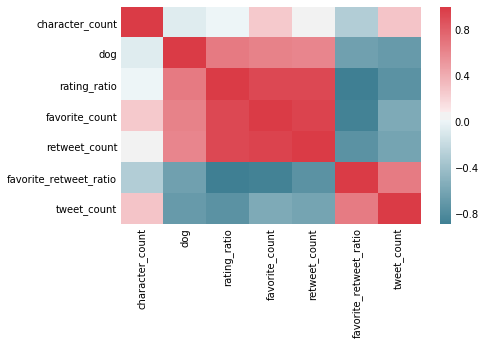

In [19]:
# visualizing the correlation matrix above, we can quickly see where the strongest correlations are

sns.heatmap(corr, xticklabels=corr.columns, 
            yticklabels=corr.columns, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True));

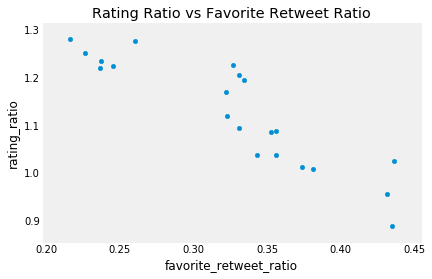

In [20]:
forcast[['favorite_retweet_ratio', 'rating_ratio']]\
.plot(kind='scatter', y='rating_ratio', x='favorite_retweet_ratio')
plt.title("Rating Ratio vs Favorite Retweet Ratio")
plt.grid();

Tweets with higher rating ratios correlate with a lower favorite_retweet_ratio.  Here we can visualize this strong negative correlation.

## Rating Ratio Forcast

In [21]:
forcast[['rating_ratio']].head(1)

,rating_ratio
created_at,
2015-11-01,0.888699


In [22]:
data = forcast[['rating_ratio']].reset_index().rename(columns={'created_at': 'ds', 'rating_ratio': 'y'})

In [29]:
tm = Prophet(seasonality_mode='additive', 
             growth='linear',
             yearly_seasonality=True,
             weekly_seasonality=False,
             daily_seasonality=False, 
             interval_width=0.95
            ).fit(data)

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.0.


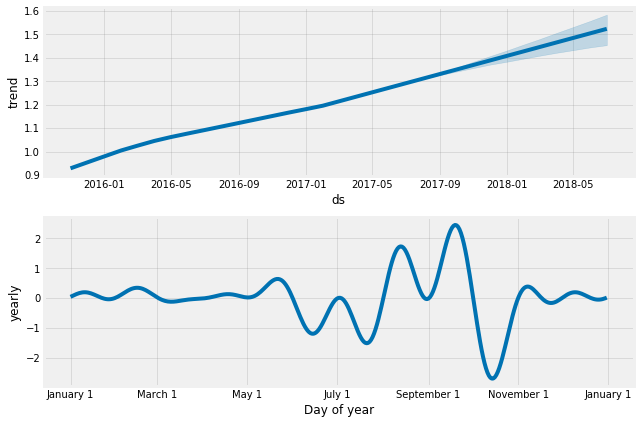

In [30]:
future = tm.make_future_dataframe(periods=12, freq='MS')
rating_forcast = tm.predict(future)

tm.plot_components(rating_forcast);

There is a strong positive trend indicating that the ratings have been steadily increasing since the inception of the WeRateDogs twitter account.  There also appears to be a minor amount of seasonality around the seasonal change of summer to fall.  Looking below, this is much more pronounced in 2017 than 2016 and the lack of data points be an indication as to why this is the case.

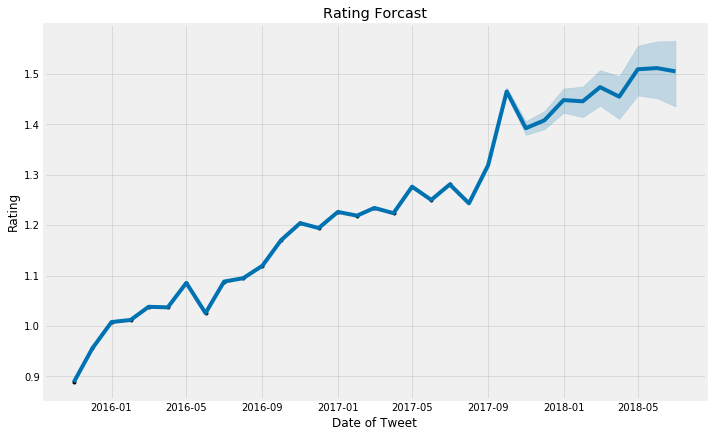

In [31]:
tm.plot(rating_forcast, xlabel='Date of Tweet', ylabel='Rating')
plt.title("Rating Forcast");

Upon forcasting the mean monthly rating for an additional 12 month period, we can see that this positive trend continues - in fact there is a 95% chance that the calcualted confidence interval (shaded region) between approximately 1.44 and 1.56 will contain the actual monthly mean rating in the following months.